In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from HW2.benchmark_proceeder import BenchmarkStorage
from HW2.regression_generator import generate_regression
from HW2.sgd import sgd, minibatch_gd, gd
from HW2.visualization import visualize_regression_point, visualize_line, draw_levels
from HW2.optimization import *

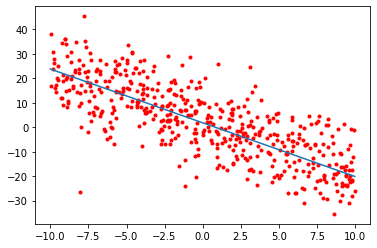

In [2]:
f, points = generate_regression(point_count=500, scale=3, y_scale=10)

visualize_regression_point(f, points)

storage = BenchmarkStorage()

# No optimizations

[-1.90055774  0.70987111]
Benchmark results for config <('sgd', 1, Default(no) optimization, Squared error calculator)>:
Mean time:0.032036
Mean memory:0.0B
Mean SMAPE value:0.449334427419598
Mean RMSE value:9.874291334989152
Mean logcosh value:7.197500022094741
Mean gradient calls:370.0
Iterations done:370.0


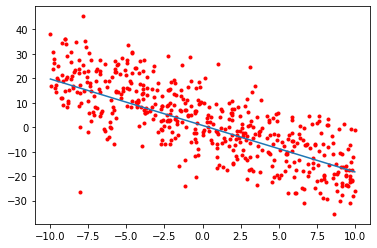

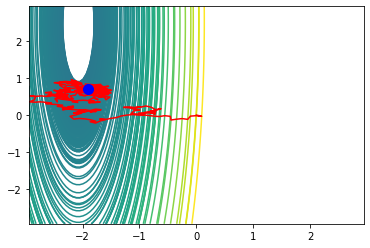

In [3]:
index = storage.add_benchmark_config()
ab, meta = sgd(points)
storage.add_benchmark_result(index, meta)

print(ab)
print(storage.get_benchmark_results(index))

visualize_line(ab, points)
draw_levels(points, meta["points"])

# Momentum optimization

[-2.90698844  0.51253747]
Benchmark results for config <('sgd', 1, Momentum optimization (beta=0.95), Squared error calculator)>:
Mean time:0.013262
Mean memory:0.0B
Mean SMAPE value:0.4322983393881508
Mean RMSE value:10.944404914438492
Mean logcosh value:7.994118472802873
Mean gradient calls:119.0
Iterations done:119.0


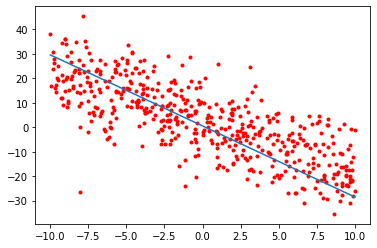

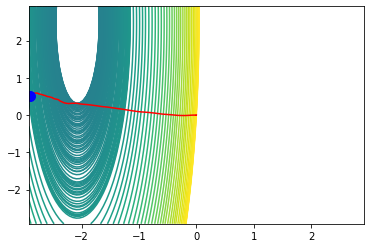

In [4]:
optimization = MomentumOptimization(beta=0.95)
index = storage.add_benchmark_config(optimiser=optimization)
ab, meta = sgd(points, optimization=optimization)
storage.add_benchmark_result(index, meta)

print(ab)
print(storage.get_benchmark_results(index))

visualize_line(ab, points)
draw_levels(points, meta["points"])

#### Наблюдения

* Функция стала более сглаженной из-за бегущего среднего по градиентам и происходит некая "имитация" `Minibatch GD`

# Nesterov optimization

[-1.98613174  0.77290556]
Benchmark results for config <('sgd', 1, Nesterov optimization (beta=0.95), Squared error calculator)>:
Mean time:0.014923
Mean memory:0.0B
Mean SMAPE value:0.44349509746678567
Mean RMSE value:9.826826861981889
Mean logcosh value:7.147119785366684
Mean gradient calls:143.0
Iterations done:143.0


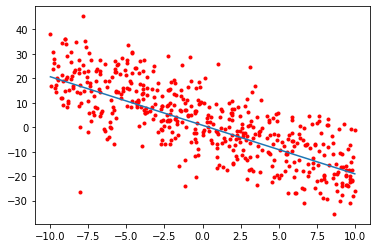

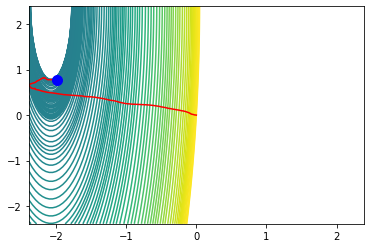

In [12]:
optimization = NesterovOptimization(beta=0.95)
index = storage.add_benchmark_config(optimiser=optimization)
ab, meta = sgd(points, optimization=optimization)
storage.add_benchmark_result(index, meta)

print(ab)
print(storage.get_benchmark_results(index))

visualize_line(ab, points)
draw_levels(points, meta["points"])

#### Наблюдения

* Также, так и в `Momentum`, есть бегущее среднее по градиентам, что делает функцию более гладкой
* Но сходимся мы лучше т.к. берем градиент от точки бегущего среднего, а не от изначальной

# AdaGrad optimization

[-1.69996598  0.63668675]
Benchmark results for config <('sgd', 1, Ada gradient optimization (eps=1e-05), Squared error calculator)>:
Mean time:0.087339
Mean memory:0.0B
Mean SMAPE value:0.4645168716239719
Mean RMSE value:10.065055399444738
Mean logcosh value:7.379669413415615
Mean gradient calls:602.0
Iterations done:602.0


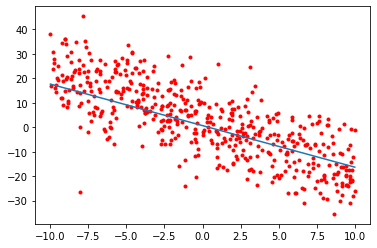

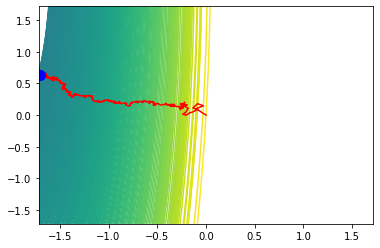

In [17]:
optimization = AdaGradOptimization()
ab, meta = sgd(points, optimization=optimization, eps=5e-3)
storage.add_benchmark_result(index, meta)

print(ab)
print(storage.get_benchmark_results(index))

visualize_line(ab, points)
index = storage.add_benchmark_config(optimiser=optimization)
draw_levels(points, meta["points"])

#### Наблюдения

* Шаги делаем не такие широкие, так как берем сумму квадратов градиентов и делим на `lr`
* Из-за этого уменьшаем `eps` $\Rightarrow$ увеличивается точность схождения
* Из-за этого же есть затухание градиента, что хорошо для некоторого типа задач

# RMSProp optimization

[-1.69328535  0.37029882]
Benchmark results for config <('sgd', 1, RMS prop optimization (gamma=0.95, eps=1e-05), Squared error calculator)>:
Mean time:0.054184
Mean memory:0.0B
Mean SMAPE value:0.4666002581211901
Mean RMSE value:10.125081753177612
Mean logcosh value:7.4287232766845115
Mean gradient calls:371.0
Iterations done:371.0


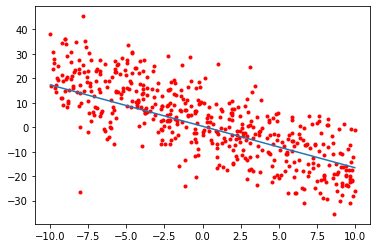

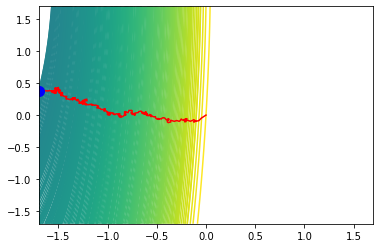

In [23]:
optimization = RMSPropOptimization(gamma=0.95)
index = storage.add_benchmark_config(optimiser=optimization)
ab, meta = sgd(points, optimization=optimization, lr=0.01, eps=1e-2)
storage.add_benchmark_result(index, meta)

print(ab)
print(storage.get_benchmark_results(index))

visualize_line(ab, points)
draw_levels(points, meta["points"])

[-2.10620585  2.66076501]
Benchmark results for config <('sgd', 1, RMS prop optimization (gamma=0.95, eps=1e-05), Squared error calculator)>:
Mean time:0.420272
Mean memory:0.0B
Mean SMAPE value:0.4330408960055436
Mean RMSE value:9.671765104782475
Mean logcosh value:7.0175490764772785
Mean gradient calls:47350.0
Iterations done:947.0


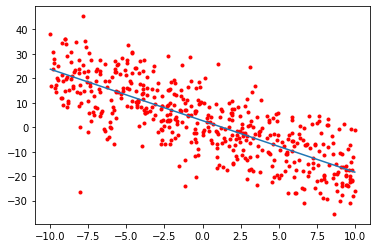

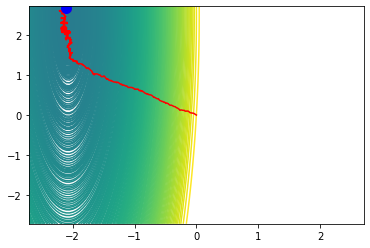

In [24]:
optimization = RMSPropOptimization(gamma=0.95)
index = storage.add_benchmark_config(optimiser=optimization)
ab, meta = minibatch_gd(points, batch_size=50, optimization=optimization, lr=0.01, eps=1e-2)
storage.add_benchmark_result(index, meta)

print(ab)
print(storage.get_benchmark_results(index))

visualize_line(ab, points)
draw_levels(points, meta["points"])

#### Наблюдения

* Как и в предыдущем методе, мы накапливаем сумму квадратов градиента, но у же бегущее среднее по ним
* А значит функция становится более гладкой
* Это позволяет более точно идти в нужном направлении
* И как следствие -- гораздо дальше (`eps` уменьшаем)

# Adam optimization

[-2.49714075  1.75274668]
Benchmark results for config <('sgd', 1, Adam optimization (beta_1=0.9, beta_2=0.999, eps=1e-05), Squared error calculator)>:
Mean time:0.120393
Mean memory:0.0B
Mean SMAPE value:0.4241000342976378
Mean RMSE value:9.99084047228122
Mean logcosh value:7.2203466723204635
Mean gradient calls:1026.0
Iterations done:1026.0


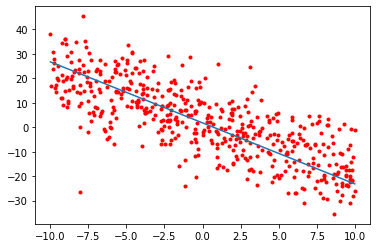

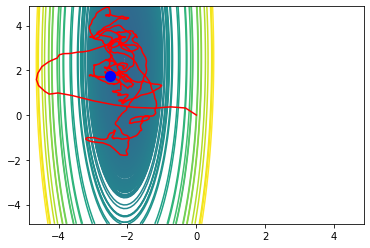

In [9]:
optimization = AdamOptimization()
index = storage.add_benchmark_config(optimiser=optimization)
ab, meta = sgd(points, optimization=optimization)
storage.add_benchmark_result(index, meta)

print(ab)
print(storage.get_benchmark_results(index))

visualize_line(ab, points)
draw_levels(points, meta["points"])

[-2.13316103  2.5359853 ]
Benchmark results for config <('sgd', 1, Adam optimization (beta_1=0.9, beta_2=0.999, eps=1e-05), Squared error calculator)>:
Mean time:0.736372
Mean memory:0.0B
Mean SMAPE value:0.4317941684995904
Mean RMSE value:9.674357601710856
Mean logcosh value:7.015908324246122
Mean gradient calls:92900.0
Iterations done:1858.0


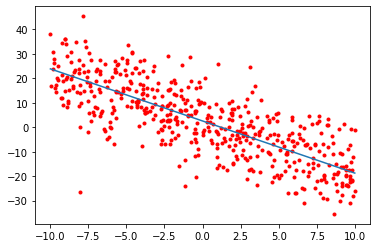

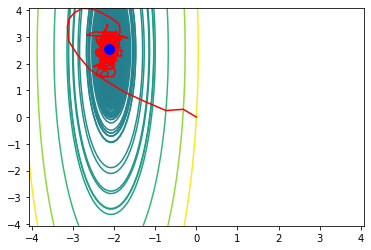

In [25]:
optimization = AdamOptimization()
index = storage.add_benchmark_config(optimiser=optimization)
ab, meta = minibatch_gd(points, batch_size=50, optimization=optimization)
storage.add_benchmark_result(index, meta)

print(ab)
print(storage.get_benchmark_results(index))

visualize_line(ab, points)
draw_levels(points, meta["points"])

#### Наблюдения

* `Adam` является объединением всех вышеупомянутых идей
* Это позволяет ему сходиться гораздо точнее и гораздо быстрее

# Benchmark

In [26]:
optimizators = [DefaultOptimization(), MomentumOptimization(0.95), NesterovOptimization(0.95), AdaGradOptimization(),
                RMSPropOptimization(0.5), AdamOptimization()]

result = np.array([])
for optimization in tqdm(optimizators, "Optimization"):
    index = storage.add_benchmark_config(optimiser=optimization)
    for _ in range(20):
        ab, meta = minibatch_gd(points, optimization=optimization)
        storage.add_benchmark_result(index, meta)
    result = np.append(result, storage.get_benchmark_results_arrayed(index))

result = result.reshape((-1, 8))
df = pd.DataFrame(result, columns=[
    'Config',
    'Mean time',
    'Mean mem',
    'Mean SMAPE',
    'Mean RMSE',
    'Mean logcosh',
    'Mean gradient calls',
    'Mean iterations'
])
df.to_csv("data/2.3.csv", sep='\t')
df

Optimization:   0%|          | 0/6 [00:00<?, ?it/s]

,Config,Mean time,Mean mem,Mean SMAPE,Mean RMSE,Mean logcosh,Mean gradient calls,Mean iterations
0,"(sgd, 1, Default(no) optimization, Squared err...",0.016135,0.0B,0.44611,9.909869,7.21425,194.4,194.4
1,"(sgd, 1, Momentum optimization (beta=0.95), Sq...",0.006729,0.0B,0.456168,10.256027,7.490478,86.05,86.05
2,"(sgd, 1, Nesterov optimization (beta=0.95), Sq...",0.005927,0.0B,0.459059,10.204607,7.46318,77.1,77.1
3,"(sgd, 1, Ada gradient optimization (eps=1e-05)...",0.003547,0.0B,0.862253,14.664011,11.28224,50.0,50.0
4,"(sgd, 1, RMS prop optimization (gamma=0.5, eps...",1.000257,0.0B,0.438699,9.889631,7.182493,10000.0,10000.0
5,"(sgd, 1, Adam optimization (beta_1=0.9, beta_2...",0.037055,0.0B,0.43335,9.998439,7.255784,386.2,386.2
